<h1> <strong> Carga de librerías

In [1]:
!pip install -U datasets -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.6 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is incompatible.
torch 2.6.0+

In [2]:
import torch
import numpy as np
import re
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from transformers import AutoImageProcessor, ViTForImageClassification
from datasets import Dataset
from collections import defaultdict

In [3]:
from huggingface_hub import login
login()

<h1> <strong> Carga del modelo

In [4]:
processor = AutoImageProcessor.from_pretrained("JeiGeek/landmines-detection-xvvaagkj")
model = ViTForImageClassification.from_pretrained("JeiGeek/landmines-detection-xvvaagkj")

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

<h1> <strong> Preparar particion test

In [6]:
from datasets import load_dataset

# Cargar el dataset particionado desde Hugging Face
dataset = load_dataset("JeiGeek/dataset_landmine_particionado")

# Ver el contenido del dataset
print(dataset)

# Ver tamaños de las particiones
print(f"Tamaño train: {len(dataset['train'])}")
print(f"Tamaño test: {len(dataset['test'])}")

test_dataset = dataset['test']

README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/157M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1040 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/261 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 1040
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 261
    })
})
Tamaño train: 1040
Tamaño test: 261


<h2> <strong> Realizamos las transformaciones

In [8]:
def preprocess(example):
    inputs = processor(images=example["image"], return_tensors="pt")
    example["pixel_values"] = inputs["pixel_values"].squeeze()  # remove batch dim
    return example

test_dataset = test_dataset.with_transform(preprocess)

In [9]:
def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = torch.tensor([x["label"] for x in batch])
    return {"pixel_values": pixel_values, "labels": labels}


<h2> <strong> Clase para cargar las imagenes test y aplicar transformaciones

In [10]:
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

<h1> <strong> Desactivar cálculo de gradientes.

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

<h1> <strong> Calcular métricas y salida

In [12]:
import numpy as np

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)  # same as recall for binary
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")


Accuracy: 0.9923
Precision: 1.0000
Sensitivity (Recall): 0.9487
Specificity: 1.0000


<h1> <strong> Evaluación por altitud y profundidad

<h2> <strong> Clasificación por profundidad

In [13]:
import re
from collections import defaultdict

# Crear un diccionario para agrupar las imágenes según su clasificación
clasificados = defaultdict(list)

# Función para clasificar las imágenes según el nombre del archivo
def clasificar_imagen(filename):
    # Caso donde no hay mina (free)
    if "free" in filename:
        return "No Mina"  # Aquí asignamos 'No Mina' a las imágenes que contienen 'free'

    # Caso donde es una mina en la superficie (Sruface) Error del dataset >:(
    if "Sruface" in filename:
        return "0cm"  # 'Surface' se clasifica como 0 (sin profundidad)

    # Caso donde es una mina en la superficie (Surface)
    if "Surface" in filename:
        return "0cm"  # 'Surface' se clasifica como 0 (sin profundidad)

    # Clasificación para 1cm, 5cm
    if "1cm" in filename:
        return "1cm"

    if "5cm" in filename:
        return "5cm"

    if "5" in filename:
        return "5cm"

    # Clasificación para 10 (no tiene 'cm', solo el número '10')
    if "10" in filename:
        return "10cm"

    # Si no se encuentra ninguna de las condiciones anteriores
    return "1cm"  # Un fallo con las de 1cm que aparece 1 sin el cm

# Recorrer el test_dataset y clasificar las imágenes
for example in test_dataset:
    filename = example['filename']
    # Clasificar la imagen según el nombre del archivo
    label = clasificar_imagen(filename)

    # Guardar la imagen y su etiqueta clasificada en el diccionario
    clasificados[label].append(example)

# Ver el resultado de las clasificaciones
for label, images in clasificados.items():
    print(f"Clase {label}: {len(images)} imágenes")


Clase 0cm: 53 imágenes
Clase 1cm: 90 imágenes
Clase No Mina: 39 imágenes
Clase 10cm: 23 imágenes
Clase 5cm: 56 imágenes


<h2> <strong> Clasificación por rango de altura del dron

In [70]:
import re
from collections import defaultdict

# Crear un diccionario para agrupar las imágenes según su altura
class_altura = defaultdict(list)

# Función para clasificar las imágenes según el nombre del archivo (por altura)
def clasificar_por_altura(filename):
    # Buscar la altura después de 'FlightAltitude__' en el nombre del archivo
    match_height = re.search(r'FlightAltitude__([\d\.-]+)m', filename)
    if match_height:
        height = float(match_height.group(1))

        # Clasificar por rangos de altura
        if height <= 1:
            return "0-1m"
        elif 1 < height <= 2:
            return "1-2m"
        elif 2 < height <= 3:
            return "2-3m"
        elif 3 < height <= 4:
            return "3-4m"
        elif 4 < height <= 5:
            return "4-5m"
        elif 5 < height <= 6:
            return "5-6m"
        elif 6 < height <= 7:
            return "6-7m"
        elif 7 < height <= 8:
            return "7-8m"
        elif 8 < height <= 9:
            return "8-9m"
        elif 9 < height <= 10:
            return "9-10m"
        elif 10 < height <= 11:
            return "10-11m"

    # Si no se encuentra la altura o el formato es incorrecto
    return "Desconocido"

# Recorrer el test_dataset y clasificar las imágenes por altura
for example in test_dataset:
    filename = example['filename']
    # Clasificar la imagen según su altura
    label = clasificar_por_altura(filename)

    # Guardar la imagen y su etiqueta clasificada en el diccionario class_altura
    class_altura[label].append(example)

# Ver el resultado de las clasificaciones por altura
for label, images in class_altura.items():
    print(f"Clase {label}: {len(images)} imágenes")


Clase 8-9m: 20 imágenes
Clase 3-4m: 28 imágenes
Clase 6-7m: 20 imágenes
Clase 2-3m: 39 imágenes
Clase 0-1m: 30 imágenes
Clase 7-8m: 23 imágenes
Clase 9-10m: 23 imágenes
Clase 4-5m: 14 imágenes
Clase 1-2m: 48 imágenes
Clase 5-6m: 13 imágenes
Clase 10-11m: 3 imágenes


In [18]:
import re
from collections import defaultdict

# Crear un diccionario para agrupar las imágenes según su altura
class_altura = defaultdict(list)

# Función para clasificar las imágenes según el nombre del archivo (por altura)
def clasificar_por_altura(filename):
    # Buscar la altura después de 'FlightAltitude__' en el nombre del archivo
    match_height = re.search(r'FlightAltitude__([\d\.-]+)m', filename)
    if match_height:
        height = float(match_height.group(1))

        # Clasificar por rangos de altura
        if height <= 2:
            return "2m"
        elif 2 < height <= 3:
            return "3m"
        elif 3 < height <= 4:
            return "4m"
        elif 4 < height <= 5:
            return "5m"
        elif 5 < height <= 6:
            return "6m"
        elif 6 < height <= 7:
            return "7m"
        elif 7 < height <= 8:
            return "8m"
        elif 8 < height <= 9:
            return "9m"
        elif 9 < height <= 11:
            return "10m"

    # Si no se encuentra la altura o el formato es incorrecto
    return "Desconocido"

# Recorrer el test_dataset y clasificar las imágenes por altura
for example in test_dataset:
    filename = example['filename']
    # Clasificar la imagen según su altura
    label = clasificar_por_altura(filename)

    # Guardar la imagen y su etiqueta clasificada en el diccionario class_altura
    class_altura[label].append(example)

# Ver el resultado de las clasificaciones por altura
for label, images in class_altura.items():
    print(f"Clase {label}: {len(images)} imágenes")

Clase 9m: 20 imágenes
Clase 4m: 28 imágenes
Clase 7m: 20 imágenes
Clase 3m: 39 imágenes
Clase 2m: 78 imágenes
Clase 8m: 23 imágenes
Clase 10m: 26 imágenes
Clase 5m: 14 imágenes
Clase 6m: 13 imágenes


<h2> <strong> Función de evaluación de categorías

In [15]:
def evaluacion_por_categoria (coleccion):
    class_data = coleccion
    
    # Convertir a un Dataset
    class_dataset_1 = Dataset.from_dict({
        'image': [example['image'] for example in class_data],
        'label': [example['label'] for example in class_data],
        'filename': [example['filename'] for example in class_data]
    })
     
    # Cargar el procesador y el modelo
    processor = AutoImageProcessor.from_pretrained("JeiGeek/landmines-detection-xvvaagkj")
    model = ViTForImageClassification.from_pretrained("JeiGeek/landmines-detection-xvvaagkj")
    
    # Aplicar preprocesamiento a las imágenes del dataset
    def preprocess(example):
        inputs = processor(images=example["image"], return_tensors="pt")
        example["pixel_values"] = inputs["pixel_values"].squeeze()  # remove batch dim
        return example
    
    # Aplicar preprocesamiento
    class_dataset_1 = class_dataset_1.with_transform(preprocess)
    
    # Función para agrupar los datos en batches
    def collate_fn(batch):
        pixel_values = torch.stack([x["pixel_values"] for x in batch])
        labels = torch.tensor([x["label"] for x in batch])
        return {"pixel_values": pixel_values, "labels": labels}
    
    # Cargar el dataset en un DataLoader
    test_loader = DataLoader(class_dataset_1, batch_size=32, collate_fn=collate_fn)
    
    # Evaluar el modelo
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    # Realizar inferencias sin calcular gradientes
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
    
            # Obtener las predicciones
            outputs = model(inputs)
            preds = torch.argmax(outputs.logits, dim=1)
    
            # Almacenar las predicciones y las etiquetas
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convertir las listas a arrays
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Calcular las métricas sin incluir la Specificity
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=1)  # Usamos binary para evaluar correctamente las predicciones
    sensitivity = recall_score(y_true, y_pred, average='binary', zero_division=1)  # Sensibilidad o recall
    # No calculamos specificity porque no tenemos ejemplos de no mina
    
    # Imprimir las métricas
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")

    return accuracy, precision, sensitivity

<h3> <strong> Evaluación por profundidad de mina

In [51]:
evaluacion_por_categoria(clasificados['10cm'])

Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000


In [24]:
accuracies_p = []
precisions_p = []
sensitivities_p = []

for i in clasificados:
    if i != 'No Mina':
        print("-"*30)
        print(f"Minas que se encuentran en {i}:")
        
        accuracy, precision, sensitivity = evaluacion_por_categoria(clasificados[i])
        
        accuracies_p.append(accuracy)
        precisions_p.append(precision)
        sensitivities_p.append(sensitivity)
        
        print("-"*30)
        print("\n")

------------------------------
Minas que se encuentran en 0cm:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Minas que se encuentran en 1cm:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Minas que se encuentran en 10cm:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Minas que se encuentran en 5cm:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------




<h3> <strong> Evaluación por altura del dron

In [19]:
accuracies_a = []
precisions_a = []
sensitivities_a = []

for categoria in class_altura:
    print("-"*30)
    print(f"Cuando el dron se encuentran entre {categoria} de altura:")
    
    accuracy, precision, sensitivity = evaluacion_por_categoria(class_altura[categoria])

    accuracies_a.append(accuracy)
    precisions_a.append(precision)
    sensitivities_a.append(sensitivity)
    
    print("-"*30)
    print("\n")

------------------------------
Cuando el dron se encuentran entre 9m de altura:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Cuando el dron se encuentran entre 4m de altura:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Cuando el dron se encuentran entre 7m de altura:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Cuando el dron se encuentran entre 3m de altura:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
------------------------------


------------------------------
Cuando el dron se encuentran entre 2m de altura:
Accuracy: 0.9872
Precision: 1.0000
Sensitivity (Recall): 0.9286
------------------------------


------------------------------
Cuando el dron se encuentran entre 8m de altura:
Accuracy: 1.0000
Precision: 1.0000


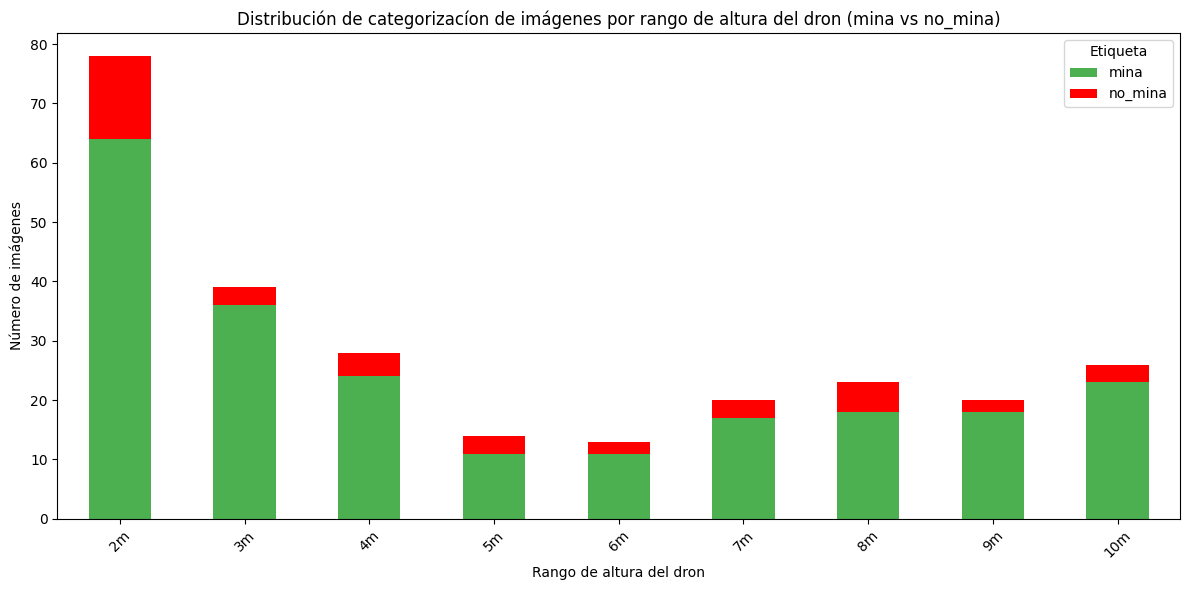

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# categoria ya tiene las clases ordenadas
# clasificados tiene las listas de imágenes con su 'label'
img_totales = 0

orden_clases = [
    '2m', "3m", "4m", "5m",
    "6m", "7m", "8m", "9m", "10m"
]

conteo_data = {
    'clase': [],      # esta clave
    'no_mina': [],
    'mina': []
}

for clase in orden_clases:
    
    tam_img = len(class_altura[clase])
    if tam_img >= img_totales:
        img_totales = tam_img

    imagenes = class_altura[clase]

    mina = 0
    no_mina = 0
    
    for num in range(len(imagenes)):
        if imagenes[num]['label'] == 0:
            mina += 1
        if imagenes[num]['label'] == 1:
            no_mina += 1

    conteo_data['clase'].append(clase)
    conteo_data['no_mina'].append(no_mina)
    conteo_data['mina'].append(mina)

# Crear DataFrame para graficar
df_conteo = pd.DataFrame(conteo_data)
df_conteo.set_index('clase', inplace=True)

# Graficar barras apiladas
df_conteo[['mina', 'no_mina']].plot(
    kind='bar',
    stacked=True,
    color=['#4CAF50', '#FF0000'],  # verde para mina, rojo para no mina
    figsize=(12, 6)
)

plt.title('Distribución de categorizacíon de imágenes por rango de altura del dron (mina vs no_mina)')
plt.xlabel('Rango de altura del dron')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.legend(title="Etiqueta")
plt.tight_layout()
plt.show()


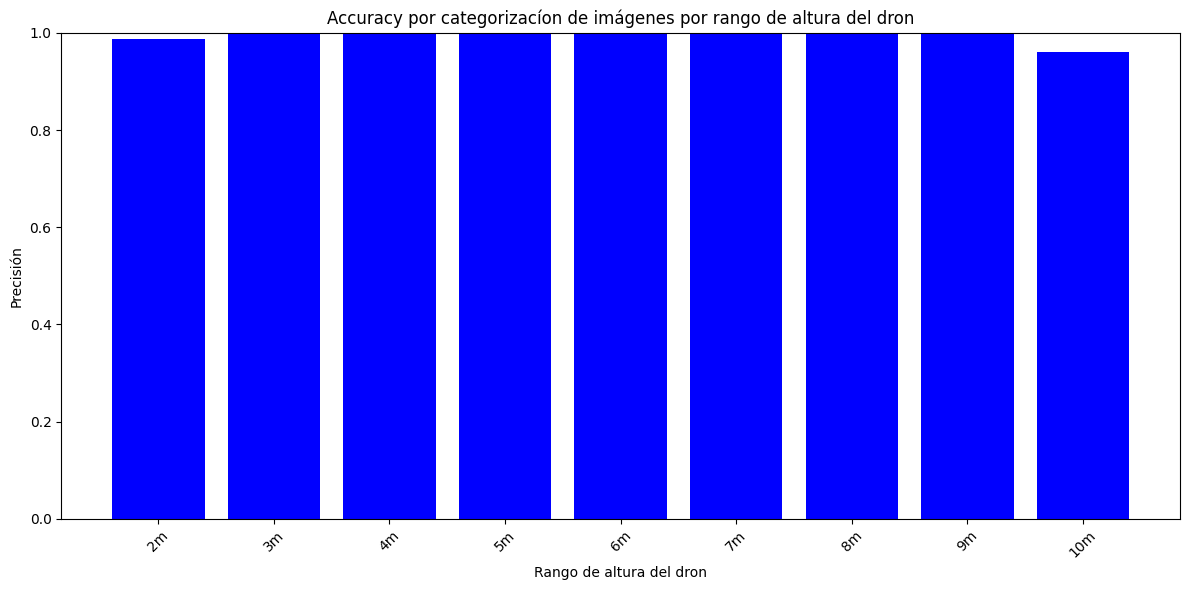

In [23]:
import matplotlib.pyplot as plt

# Orden tradicional de clases
orden_clases = [
    '2m', "3m", "4m", "5m",
    "6m", "7m", "8m", "9m", "10m"
]

# Orden de los datos en precisions_a
orden_accuracy = [
    '9m', '4m', '7m', '3m', '2m', 
    '8m', '10m', '5m', '6m'
]

# Diccionario que mapea clase → precisión
precision_dict = dict(zip(orden_accuracy, accuracies_a))

# Reordenar según orden_clases
precisiones_ordenadas = [precision_dict[clase] for clase in orden_clases]

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(orden_clases, precisiones_ordenadas, color='blue')
plt.title('Accuracy por categorizacíon de imágenes por rango de altura del dron')
plt.xlabel('Rango de altura del dron')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


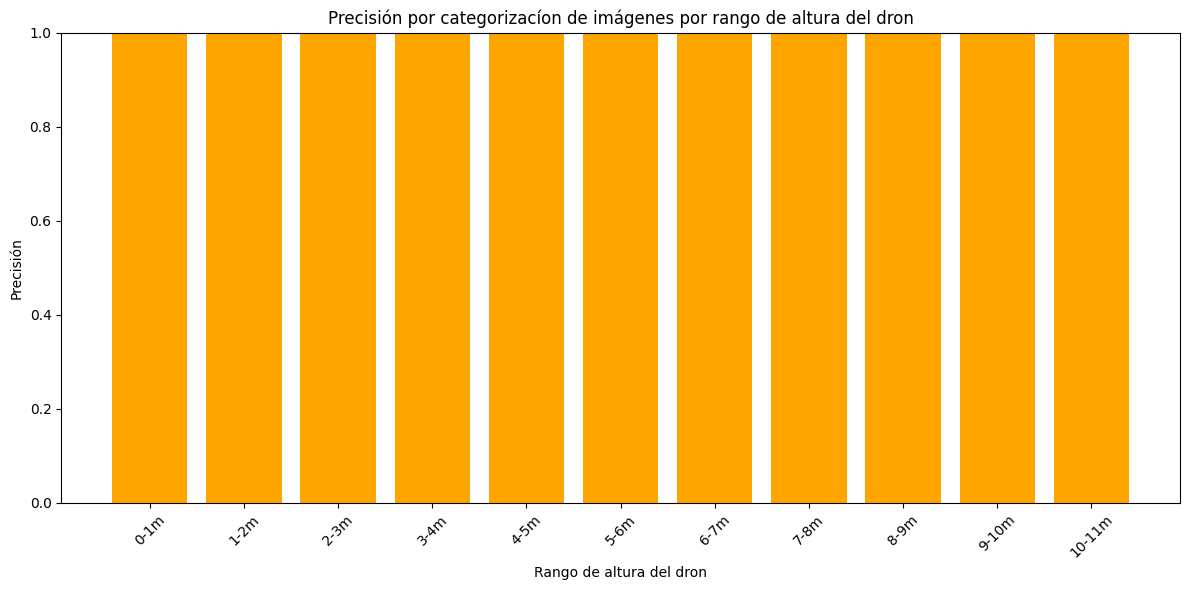

In [147]:
import matplotlib.pyplot as plt

# Orden tradicional de clases
orden_clases = [
    '0-1m', '1-2m', '2-3m', '3-4m', '4-5m',
    '5-6m', '6-7m', '7-8m', '8-9m', '9-10m', '10-11m'
]

# Orden de los datos en precisions_a
orden_precisions = [
    '8-9m', '3-4m', '6-7m', '2-3m', '0-1m', 
    '7-8m', '9-10m', '4-5m', '1-2m', '5-6m', '10-11m'
]

# Diccionario que mapea clase → precisión
precision_dict = dict(zip(orden_precisions, precisions_a))

# Reordenar según orden_clases
precisiones_ordenadas = [precision_dict[clase] for clase in orden_clases]

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(orden_clases, precisiones_ordenadas, color='orange')
plt.title('Precisión por categorizacíon de imágenes por rango de altura del dron')
plt.xlabel('Rango de altura del dron')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


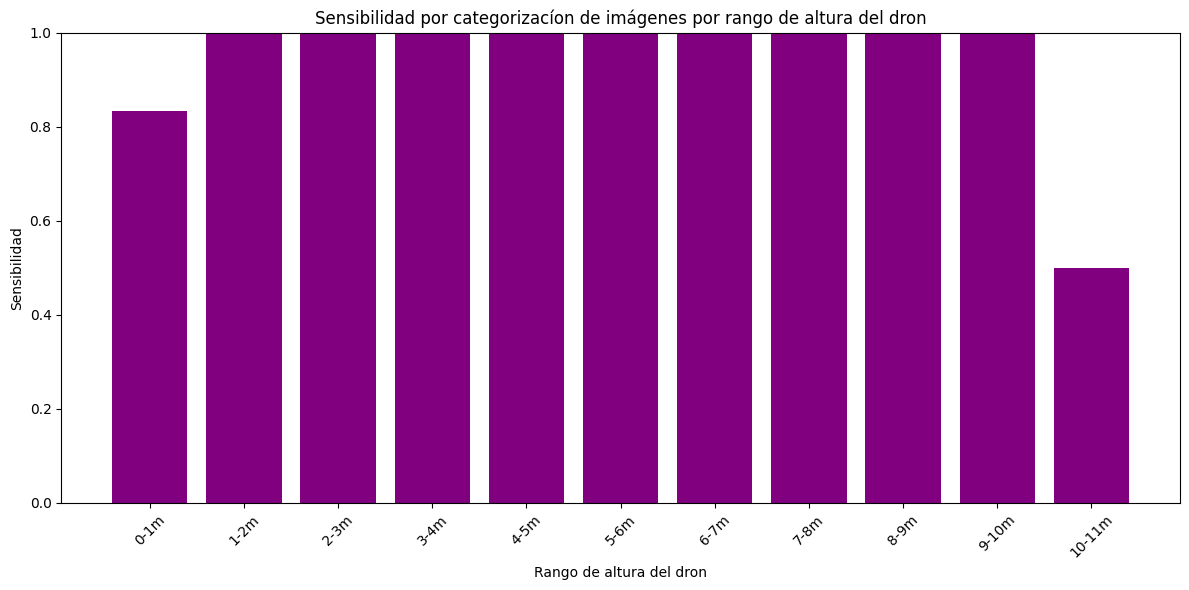

In [145]:
# Orden tradicional de clases
orden_clases = [
    '0-1m', '1-2m', '2-3m', '3-4m', '4-5m',
    '5-6m', '6-7m', '7-8m', '8-9m', '9-10m', '10-11m'
]

# Orden en el que están los datos de sensitivities_a
orden_sensitivities = [
    '8-9m', '3-4m', '6-7m', '2-3m', '0-1m', 
    '7-8m', '9-10m', '4-5m', '1-2m', '5-6m', '10-11m'
]

# Diccionario que mapea clase → sensibilidad
sensibilidad_dict = dict(zip(orden_sensitivities, sensitivities_a))

# Reordenar según orden_clases
sensibilidades_ordenadas = [sensibilidad_dict[clase] for clase in orden_clases]

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(orden_clases, sensibilidades_ordenadas, color='purple')
plt.title('Sensibilidad por categorizacíon de imágenes por rango de altura del dron')
plt.xlabel('Rango de altura del dron')
plt.ylabel('Sensibilidad')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()